<a href="https://colab.research.google.com/github/tejaspradhan/Graph-Neural-Networks/blob/main/emotion-analysis-gnn/Google_EA_TextGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -U tf_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
from tf_geometric.utils import tf_utils

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
# # In case of any corpus are missing 
# download all-nltk
nltk.download('stopwords')
stop_words = stopwords.words("english")

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
import tensorflow as tf
import tf_geometric as tfg
import pickle
import re

/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.

## Downloading and Exploring Data

In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat './kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
!kaggle datasets download -d shivamb/go-emotions-google-emotions-dataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [6]:
!unzip /content/go-emotions-google-emotions-dataset.zip

Archive:  /content/go-emotions-google-emotions-dataset.zip
replace go_emotions_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: go_emotions_dataset.csv  


In [7]:
data = pd.read_csv('/content/go_emotions_dataset.csv')

In [8]:
data.shape

(211225, 31)

In [9]:
data.drop(data[data['example_very_unclear']==True].index,inplace=True)

In [10]:
data.isna().sum()

id                      0
text                    0
example_very_unclear    0
admiration              0
amusement               0
anger                   0
annoyance               0
approval                0
caring                  0
confusion               0
curiosity               0
desire                  0
disappointment          0
disapproval             0
disgust                 0
embarrassment           0
excitement              0
fear                    0
gratitude               0
grief                   0
joy                     0
love                    0
nervousness             0
optimism                0
pride                   0
realization             0
relief                  0
remorse                 0
sadness                 0
surprise                0
neutral                 0
dtype: int64

In [11]:
data.columns

Index(['id', 'text', 'example_very_unclear', 'admiration', 'amusement',
       'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
       'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment',
       'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
       'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse',
       'sadness', 'surprise', 'neutral'],
      dtype='object')

## Data Preprocessing

In [12]:
def clean_text(x):
  x = x.lower()
  x = ' '.join([word for word in x.split(' ') if word not in stop_words])
  x = x.encode('ascii', 'ignore').decode()
  x = re.sub(r'https*\S+', ' ', x)
  x = re.sub(r'@\S+', ' ', x)
  x = re.sub(r'#\S+', ' ', x)
  x = re.sub(r'\'\w+', '', x)
  x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
  x = re.sub(r'\w*\d+\w*', '', x)
  x = re.sub(r'\s{2,}', ' ', x)
  return x

In [13]:
data['text'] = data['text'].apply(clean_text)

In [14]:
texts = data['text']
print(texts.shape)
labels = data[['admiration', 'amusement',
       'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
       'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment',
       'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
       'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse',
       'sadness', 'surprise', 'neutral']]
print(labels.shape)

(207814,)
(207814, 28)


In [15]:
train_texts,test_texts,train_labels,test_labels = train_test_split(texts,labels)

In [16]:
print(train_texts.shape)
print(test_texts.shape)
print(train_labels.shape)
print(test_labels.shape)


(155860,)
(51954,)
(155860, 28)
(51954, 28)


In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [18]:
class PMIModel(object):

    def __init__(self):
        self.word_counter = None
        self.pair_counter = None

    def get_pair_id(self, word0, word1):
        pair_id = tuple(sorted([word0, word1]))
        return pair_id

    def fit(self, sequences, window_size):

        self.word_counter = Counter()
        self.pair_counter = Counter()
        num_windows = 0
        for sequence in tqdm(sequences):
            for offset in range(len(sequence) - window_size):
                window = sequence[offset:offset + window_size]
                num_windows += 1
                for i, word0 in enumerate(window):
                    self.word_counter[word0] += 1
                    for j, word1 in enumerate(window[i + 1:]):
                        pair_id = self.get_pair_id(word0, word1)
                        self.pair_counter[pair_id] += 1

        for word, count in self.word_counter.items():
            self.word_counter[word] = count / num_windows
        for pair_id, count in self.pair_counter.items():
            self.pair_counter[pair_id] = count / num_windows

    def transform(self, word0, word1):
        prob_a = self.word_counter[word0]
        prob_b = self.word_counter[word1]
        pair_id = self.get_pair_id(word0, word1)
        prob_pair = self.pair_counter[pair_id]

        if prob_a == 0 or prob_b == 0 or prob_pair == 0:
           return 0

        pmi = np.log(prob_pair / (prob_a * prob_b))
        # print(word0, word1, pmi)
        pmi = np.maximum(pmi, 0.0)
        # print(pmi)
        return pmi

In [19]:
def build_word_graph(num_words, pmi_model, embedding_size):
    x = tf.Variable(tf.random.truncated_normal([num_words, embedding_size], stddev=1 / np.sqrt(embedding_size)),
                    dtype=tf.float32)
    edges = []
    edge_weight = []
    for (word0, word1) in pmi_model.pair_counter.keys():
        pmi = pmi_model.transform(word0, word1)
        if pmi > 0:
            edges.append([word0, word1])
            edge_weight.append(pmi)
            edges.append([word1, word0])
            edge_weight.append(pmi)
    edge_index = np.array(edges).T
    return tfg.Graph(x=x, edge_index=edge_index, edge_weight=edge_weight)

In [20]:
def build_combined_graph(word_graph, sequences, embedding_size):
    num_words = word_graph.num_nodes
    x = tf.zeros([len(sequences), embedding_size], dtype=tf.float32)
    edges = []
    edge_weight = []
    for i, sequence in enumerate(sequences):
        doc_node_index = num_words + i
        for word in sequence:
            edges.append([doc_node_index, word])  # only directed edge
            edge_weight.append(1.0)  # use BOW instaead of TF-IDF

    edge_index = np.array(edges).T
    x = tf.concat([word_graph.x, x], axis=0)
    edge_index = np.concatenate([word_graph.edge_index, edge_index], axis=1)
    edge_weight = np.concatenate([word_graph.edge_weight, edge_weight], axis=0)
    return tfg.Graph(x=x, edge_index=edge_index, edge_weight=edge_weight)

In [21]:
pmi_cache_path = "cached_pmi_model.p"
if os.path.exists(pmi_cache_path):
    with open(pmi_cache_path, "rb") as f:
        pmi_model = pickle.load(f)
else:
    pmi_model = PMIModel()
    pmi_model.fit(train_sequences, window_size=6)
    with open(pmi_cache_path, "wb") as f:
        pickle.dump(pmi_model, f)

embedding_size = 150
num_words = len(tokenizer.word_index) + 1
word_graph = build_word_graph(num_words, pmi_model, embedding_size)
train_combined_graph = build_combined_graph(word_graph, train_sequences, embedding_size)
test_combined_graph = build_combined_graph(word_graph, test_sequences, embedding_size)

print(word_graph)
print(train_combined_graph)
print(test_combined_graph)

num_classes =28

Graph Shape: x => (29542, 150)	edge_index => (2, 1046576)	y => None
Graph Shape: x => (185402, 150)	edge_index => (2, 2161728)	y => None
Graph Shape: x => (81496, 150)	edge_index => (2, 1417602)	y => None


In [22]:
class GCNModel(tf.keras.Model):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gcn0 = tfg.layers.GCN(100, activation=tf.nn.relu)
        self.gcn1 = tfg.layers.GCN(100, activation=tf.nn.relu)
        self.gcn2 = tfg.layers.GCN(50, activation=tf.nn.relu)
        self.gcn3 = tfg.layers.GCN(num_classes)
        self.dropout = keras.layers.Dropout(0.5)

    def call(self, inputs, training=None, mask=None, cache=None):
        x, edge_index, edge_weight = inputs
        h = self.gcn0([x, edge_index, edge_weight], cache=cache)
        h = self.gcn1([h, edge_index, edge_weight], cache=cache)
        h = self.dropout(h, training=training)
        h = self.gcn2([h, edge_index, edge_weight], cache=cache)
        h = self.gcn3([h, edge_index, edge_weight], cache=cache)
        return h

In [23]:
model = GCNModel()
model.gcn0.cache_normed_edge(train_combined_graph)
model.gcn0.cache_normed_edge(test_combined_graph)

/usr/local/lib/python3.7/dist-packages/tf_geometric/layers/conv/gcn.py:79: DeprecationWarning: 'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead
  warnings.warn("'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead", DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/tf_geometric/layers/conv/gcn.py:79: DeprecationWarning: 'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead
  warnings.warn("'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead", DeprecationWarning)


In [24]:
@tf_utils.function
def forward(graph, training=False):
    logits = model([graph.x, graph.edge_index, graph.edge_weight], cache=graph.cache, training=training)
    logits = logits[num_words:]
    return logits

In [25]:
def compute_loss(logits, labels):
    losses = tf.nn.softmax_cross_entropy_with_logits(
        logits=logits,
        labels=labels
    )
    mean_loss = tf.reduce_mean(losses)
    return mean_loss

In [31]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)

In [32]:
train_losses, test_losses = [],[]
for step in range(10000):
    with tf.GradientTape() as tape:
        logits = forward(train_combined_graph, training=True)
        # print("logits" ,logits[0],"Shape",logits[0].shape)
        mean_loss = compute_loss(logits, train_labels)
        train_losses.append(mean_loss)
    vars = tape.watched_variables()
    grads = tape.gradient(mean_loss, vars)
    optimizer.apply_gradients(zip(grads, vars))
    
    if step % 100 == 0:
        # train accuracytf.one_hot(labels, depth=num_classes)
        logits = forward(test_combined_graph)
        test_loss = compute_loss(logits, test_labels)
        print("STEP : ", step ,"  TRAIN LOSS : ",np.array(mean_loss),"  TEST LOSS: ", np.array(test_loss))
        test_losses.append(test_loss)

STEP :  0   TRAIN LOSS :  3.5425758   TEST LOSS:  3.543753
STEP :  100   TRAIN LOSS :  3.544995   TEST LOSS:  3.5464377
STEP :  200   TRAIN LOSS :  3.5501564   TEST LOSS:  3.5521436
STEP :  300   TRAIN LOSS :  3.5617607   TEST LOSS:  3.5639868
STEP :  400   TRAIN LOSS :  3.5882711   TEST LOSS:  3.5913506
STEP :  500   TRAIN LOSS :  3.6735957   TEST LOSS:  3.6761553
STEP :  600   TRAIN LOSS :  10.236349   TEST LOSS:  6.271099
STEP :  700   TRAIN LOSS :  27.160452   TEST LOSS:  17.139482
STEP :  800   TRAIN LOSS :  59.711544   TEST LOSS:  45.716797


KeyboardInterrupt: ignored

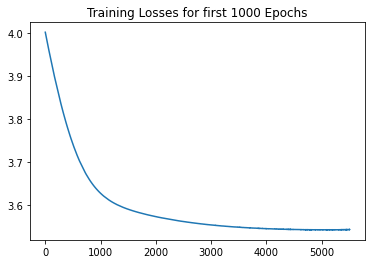

In [28]:
plt.plot(range(len(train_losses)),train_losses)
plt.title("Training Losses for first 1000 Epochs")
plt.show()

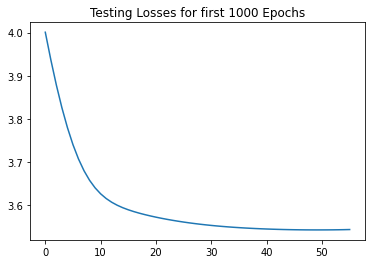

In [29]:
plt.plot(range(len(test_losses)),test_losses)
plt.title("Testing Losses for first 1000 Epochs")
plt.show()